# Load Data

8792 8968


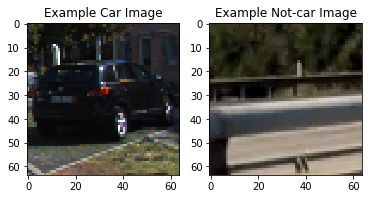

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

cars = glob.glob("vehicles\**\*.png", recursive=True)
no_cars = glob.glob("non-vehicles\**\*.png", recursive=True)
print(len(cars), len(no_cars))


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
shuffle(cars)
shuffle(no_cars)
cars_train, cars_test = train_test_split(cars, test_size=0.25)
no_cars_train, no_cars_test = train_test_split(no_cars, test_size=0.25)

# Read in car / not-car images
car_ind = np.random.randint(0, len(cars))
car_image = mpimg.imread(cars[car_ind])
notcar_ind = np.random.randint(0, len(no_cars))
notcar_image = mpimg.imread(no_cars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


#cars_train = cars_train[1:200]
#no_cars_train = no_cars_train[1:200]
#cars_test = cars_test[1:50]
#no_cars_test = no_cars_test[1:50]

# Training SVM


In [2]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time
import pickle

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
   

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel = "ALL", is_jpg = False):
     # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        if is_jpg == True:
            image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        
        # Define HOG parameters
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        spatial_features = bin_spatial(feature_image)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, hist_features, spatial_features)))
        
    # Return list of feature vectors
    return features


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6594 6726 13320 13320
7.73 Seconds to train SVC...


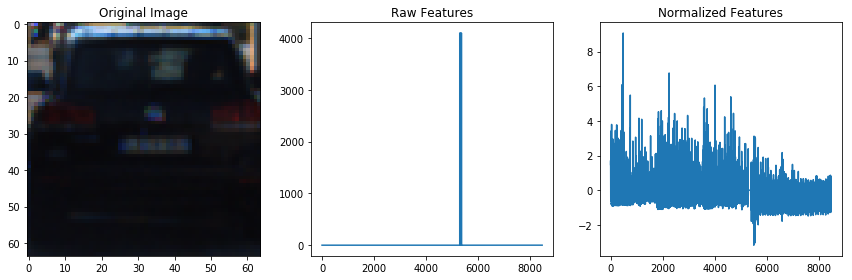

In [4]:

car_train_features = extract_features(cars_train)
no_car_train_features = extract_features(no_cars_train)
car_train_labels = np.ones(len(car_train_features)).astype(int)
no_car_train_labels = -1 * np.ones(len(no_car_train_features)).astype(int)

# Create an array stack of feature vectors
X = np.vstack((car_train_features, no_car_train_features)).astype(np.float64)
X_train_label = np.concatenate([car_train_labels, no_car_train_labels])
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_train = X_scaler.transform(X)
print(len(car_train_features), len(no_car_train_features), len(X_train), len(X_train_label))

from sklearn import svm
#from sklearn.model_selection import GridSearchCV
#parameters = {'kernel':['linear'], 'C':[1, 10]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
from sklearn.svm import LinearSVC
clf = LinearSVC()
t = time.time()
clf.fit(X_train, X_train_label)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Plot an example of raw and scaled features
car_ind = np.random.randint(0, len(cars_train))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars_train[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

# now you can save it to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)

# Test trained model

In [3]:
# and later you can load it
with open('model.pkl', 'rb') as f:
    clf = pickle.load(f)

car_test_features = extract_features(cars_test)
no_car_test_features = extract_features(no_cars_test)
car_test_labels = np.ones(len(car_test_features)).astype(int)
no_car_test_labels = -1 * np.ones(len(no_car_test_features)).astype(int)


X = np.vstack((car_test_features, no_car_test_features)).astype(np.float64)
X_test_label = np.concatenate([car_test_labels, no_car_test_labels])
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_test = X_scaler.transform(X)
print(len(car_test_features), len(no_car_test_features), len(X_test), len(X_test_label))

pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(X_test_label, pred))

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2198 2242 4440 4440
0.997072072072


# Implement Sliding Window

In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((int(startx), int(starty)), (int(endx), int(endy))))
    # Return the list of windows
    return window_list

def extract_features_image(image, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel = "ALL"):
     # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    spatial_features = bin_spatial(feature_image)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    features.append(np.concatenate((hog_features, hist_features, spatial_features)))
        
    # Return list of feature vectors
    return features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_features_image(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(1, 0, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    # Return the image
    return bboxes

def pipeline(image, clf, X_scaler):
    x_start = 480
    x_stop = image.shape[1]
    y_start = 384
    y_stop = image.shape[0] - 32
    windows = []
    
    for i in range(64, 161, 32):
        windows_iter = slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_stop], 
                            xy_window=(int(i), int(i)), xy_overlap=(0.5, 0.5))
        windows = windows + windows_iter
    
    hot_windows = search_windows(image, windows, clf, X_scaler)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    """ 
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    """
    return labels, heat


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


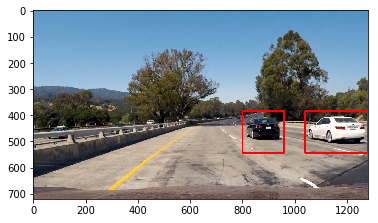

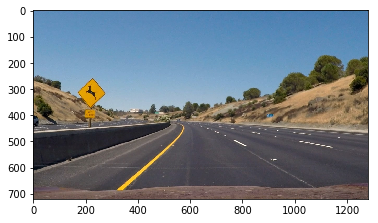

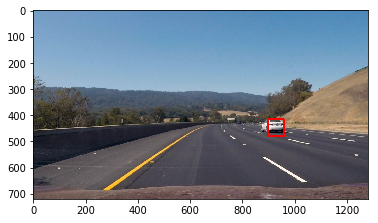

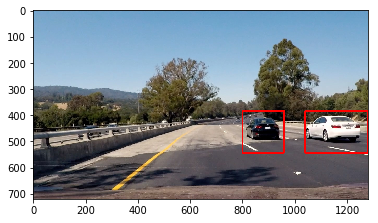

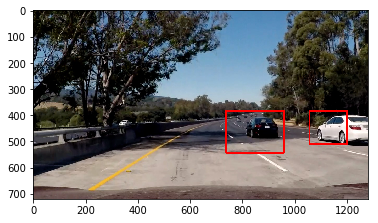

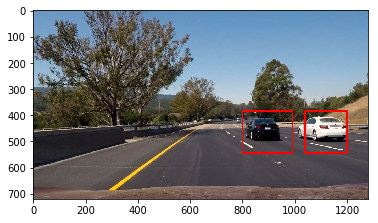

In [7]:
from scipy.ndimage.measurements import label
imgs = glob.glob("test_images\*.jpg")
count = 0
for image_name in imgs:
    image = mpimg.imread(image_name)
    # scale to 0 to 1
    image = image.astype(np.float32)/255
    labels, heat = pipeline(image, clf, X_scaler)
    bboxes = get_labeled_bboxes(labels)
    draw_image = draw_boxes(image, bboxes)
    
    plt.figure()
    plt.imshow(draw_image)

# Reduce false positives

In [8]:
class MultiFrameDetector:
    def __init__(self):
        self.heat_1 = None
        self.heat_2 = None
        self.heat_3 = None
        self.heat_4 = None
        self.heat_5 = None
        self.heat_6 = None
        
    def process_image(self, image, clf, X_scaler):
        labels, heat = pipeline(image, clf, X_scaler)
        if (self.heat_1 == None):
            self.heat_1 = heat
            return image
        
        if (self.heat_2 == None):
            self.heat_2 = heat
            return image
        
        if (self.heat_3 == None):
            self.heat_3 = heat
            return image
        
        if (self.heat_4 == None):
            self.heat_4 = heat
            return image
        
        if (self.heat_5 == None):
            self.heat_5 = heat
            return image
        
        if (self.heat_6 == None):
            self.heat_6 = heat
            return image
        
        heat_final = heat + self.heat_1 + self.heat_2 + self.heat_3 + self.heat_4 + self.heat_5 + self.heat_6
        # Apply threshold to help remove false positives
        heat_final = apply_threshold(heat_final,2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_final, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        bboxes = get_labeled_bboxes(labels)
        draw_image = draw_boxes(image, bboxes)
        
        heatmap = np.clip(heat, 0, 255)
        label_curr = label(heatmap)
        if (label_curr[1] > 0):
            self.heat_6 = self.heat_5
            self.heat_5 = self.heat_4
            self.heat_4 = self.heat_3
            self.heat_3 = self.heat_2
            self.heat_2 = self.heat_1
            self.heat_1 = heat
        
        return draw_image
    

In [9]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

detector = MultiFrameDetector()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global clf
    global X_scaler
    global detector
    
    image = image.astype(np.float32)/255
    detected = detector.process_image(image, clf, X_scaler) 
    detected = (detected*255).astype(np.uint8)
    return detected

white_output = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
del clip1

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [27:24<00:01,  1.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 27min 25s
